In [1]:
!pip install numpy matplotlib cvxopt pandas yfinance finquant plotly cufflinks chart_studio pandas_datareader atoti atoti-jupyterlab



In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import yfinance as yf
import random
from scipy.optimize import minimize
from finquant.portfolio import build_portfolio

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False
# (*) To communicate with Plotly's server, sign in with credentials file
import plotly as py  

# (*) Useful Python/Plotly tools
import plotly.tools as tls   

# (*) Graph objects to piece together plots
from plotly.graph_objs import *

import cufflinks
import atoti as tt
import urllib
import urllib.request
import random
import numpy as np

import concurrent.futures
from concurrent.futures import wait, ALL_COMPLETED
import os
import pandas_market_calendars as mcal

In [3]:
#ndays = 252*10+7
ndays = 252*1.5+7
#~training
dback = 252
#~forecast
dahead = 20
#sample size
#if to randomize
rand=True
nran = 20
nstocks = 100
#this should match tbill 20, 91, 126, 252

end = pd.Timestamp.utcnow()
start = (end - int(ndays) * pd.tseries.offsets.BDay())
one_week_end = (end - int(ndays - 7) * pd.tseries.offsets.BDay())
one_week_end = one_week_end.strftime('%Y-%m-%d')
start = start.strftime('%Y-%m-%d')
end = end.strftime('%Y-%m-%d')


In [4]:
#pd.tseries.offsets.BDay(100)
nyse = mcal.get_calendar('NYSE')

# Show available calendars
#print(mcal.get_calendar_names())
tradingDays = list(nyse.schedule(start_date=start, end_date=end).index.strftime('%Y-%m-%d'))


In [5]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

def weighted_return(returns, weights):
    w = weights
            
    p = np.asmatrix(np.mean(returns, axis=0))
    
    mu = np.asmatrix(w) * p.T
    return(mu)

def random_portfolio(returns):

    w = rand_weights(len(pd.DataFrame(returns).columns))
        
    p = np.asmatrix(np.mean(returns, axis=0))
    
    C = np.array(pd.DataFrame(returns).cov().values)
    
    mu = np.asmatrix(w) * p.T
    sigma = np.sqrt(np.asmatrix(w) * C * np.asmatrix(w).T)
    
    sharpe = mu/sigma
    
    return np.float(mu), np.float(sigma), np.float(sharpe), np.array(w,dtype=object)

def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    return(unique_list)   

def split_sequences(sequences, n_steps_in, n_steps_out):
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [6]:

url = 'ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt'

urllib.request.urlretrieve(url, 'nasdaqtraded.txt')
urllib.request.urlretrieve(url, 'mfundslist.txt')
urllib.request.urlretrieve(url, 'bonds.txt')

df1 = pd.read_csv('nasdaqtraded.txt', sep='|')[0:-1]
df2 = pd.read_csv('mfundslist.txt', sep='|')[0:-1]
df3 = pd.read_csv('bonds.txt', sep='|')[0:-1]

#combined = pd.concat([df1['Symbol'],df2['Symbol'],df3['Symbol']],axis=0)

#process symbols for bad characters
BAD_CHARS = ['$','.']
#pat = '|'.join(['({})'.format(re.escape(c)) for c in BAD_CHARS])
#cleaned = unique(combined.replace(BAD_CHARS,'-'))

#choose size
size=nstocks
#stocks = list(df1["Symbol"].sample(n=int(size/3)))
stocks = list(df1["Symbol"].replace('.','-').replace('\\$','-P',regex=True).sample(n=int(size/3)))
mfunds = list(df2["Symbol"].replace('.','-').replace('\\$','-P',regex=True).sample(n=int(size/3)))
bonds = list(df3["Symbol"].replace('.','-').replace('\\$','-P',regex=True).sample(n=int(size/3)))
symbols = unique(stocks + mfunds + bonds)
#symbols = unique(stocks)


In [7]:
pf_pre = build_portfolio(names=symbols,
                    start_date=start,
                    end_date=one_week_end,data_api='yfinance')


[*********************100%***********************]  99 of 99 completed

34 Failed downloads:
- DBDRU: Data doesn't exist for startDate = 1579586400, endDate = 1580364000
- RADI: Data doesn't exist for startDate = 1579586400, endDate = 1580364000
- TIRX: Data doesn't exist for startDate = 1579586400, endDate = 1580364000
- DBJA: Data doesn't exist for startDate = 1579586400, endDate = 1580364000
- OCAX: Data doesn't exist for startDate = 1579586400, endDate = 1580364000
- GSAH.U: No data found, symbol may be delisted
- NEE-PO: No data found for this date range, symbol may be delisted
- IMNM: Data doesn't exist for startDate = 1579586400, endDate = 1580364000
- SPRE: Data doesn't exist for startDate = 1579586400, endDate = 1580364000
- XM: Data doesn't exist for startDate = 1579586400, endDate = 1580364000
- DFPHU: Data doesn't exist for startDate = 1579586400, endDate = 1580364000
- RKT: Data doesn't exist for startDate = 1579586400, endDate = 1580364000
- GOBI: Data doesn't exist for s

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning:

Mean of empty slice.

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning:

invalid value encountered in true_divide

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\pandas\core\frame.py:8525: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply



In [8]:
vetted_symbols=list(pf_pre.data.loc[(np.intersect1d(list(pf_pre.data.index.strftime('%Y-%m-%d')), tradingDays))].head(-1).tail(-1).dropna(axis=1).columns)


In [9]:

#combinedList = unique(list(np.append(random.sample(symbols_sp500,int(len(symbols_sp500)*.05)),np.append(random.sample(dividendAristocraft,int(len(dividendAristocraft)*.25)),np.append(top10,random.sample(symbols_ns100,int(len(symbols_ns100)*.25)))))))
    
#add index
#vetted_symbols.append('TQQQ')

pf = build_portfolio(names=list(vetted_symbols),
                    start_date=start,
                    end_date=end,data_api='yfinance')



[*********************100%***********************]  65 of 65 completed


In [10]:
'''
import pandas_datareader.data as web

import datetime

# Multiple series:
fred_data = web.DataReader(FRED_Indicators, 'fred', start, end)
'''

FRED_Indicators = ['DTB4WK','DTB3','DTB6','DTB1YR']

import pandas_datareader.data as web

def Fred_Data(name):
    temp = web.DataReader(str(name), 'fred', start, end)
    temp.index = pd.to_datetime(temp.index)
    #temp = temp.resample(frequency).mean().dropna()
    return(temp)

FRED_set = []
FRED_completed = []
for i in FRED_Indicators:
    FRED_completed.append(i)
    FRED_set.append(Fred_Data(i))
                    
FRED_pvt = pd.DataFrame()

for x in range(0,len(FRED_completed)):
    values = FRED_set[x]
    values = values.loc[~values.index.duplicated(keep='last')]

    FRED_pvt = pd.concat([FRED_pvt,values], axis=1)


In [11]:

returns = np.log(1+pf.data.loc[(np.intersect1d(list(pf.data.index.strftime('%Y-%m-%d')), tradingDays))].head(-1).interpolate(method='time').pct_change().tail(-1))
returns = returns.dropna(axis=1)
#returns.columns = stocks.dropna(axis=1)
len(returns.columns)
#np.sum(returns.isin([np.inf, -np.inf, np.NaN])).sort_values(kind="quicksort", ascending=True)

65

In [12]:
selectedmfunds = (set(mfunds) & set(returns.columns))
selectedstocks = (set(stocks) & set(returns.columns))
selectedbonds = (set(bonds) & set(returns.columns))


In [13]:

n_steps_in = dback

n_steps_out = dahead

Training, Holdout = split_sequences(np.array(pd.DataFrame(returns.index.strftime('%Y-%m-%d'))), n_steps_in, n_steps_out)

In [14]:
import atoti as tt

In [15]:
test = pd.read_csv("C:\\Users\\User\\Documents\\wiki\\wiki\\dev\\python\\Python-Stock\\code\\markowitz\\returns.csv")

In [16]:
test

,stock,returns_vector
0,ATH,-0.005301677278131519;-0.0014895139771735656;0...
1,CRUS,0.006378248610582457;0.0;-0.011461752113959283...
2,LUB,0.0;0.013129279112159121;-0.044451720164367166...
3,EMB,0.002705492650867037;-0.0016571638243653385;8....
4,DOV,-0.002853628488446275;-0.0019939764051110417;0...
...,...,...
63,IEME,-0.0024552662423327795;-0.008057820722258656;0...
64,BLES,0.0015152009202108446;-0.00683684697224224;0.0...
65,SRE-PB,0.007984747189880558;-0.000990176423257015;0.0...
66,BBAX,0.0069445163018340425;-0.004624417327213878;0....


In [17]:
randomSet = list(np.sort(np.random.choice(range(0,len(Training)),nran)))

randomsymbols = list(np.random.choice(pf.data.columns,10,replace=False))
    
#random columns
stocks = returns.loc[[i[0] for i in Training[randomSet[1]]]][randomsymbols]

'''
returns_table = session.read_csv(
    "returns.csv", keys=["stock"], store_name="Returns", array_sep=";"
)

returns_table.head()
'''
return_vec = np.array(stocks)

In [18]:
stocks[randomsymbols]

,CCO,GBT,NOVA,BATRK,SPKE,IIM,FRC-PI,EFZ,SCE-PH,QSR
Date,,,,,,,,,,
2020-02-07,-0.025879,-0.014913,-0.007744,-0.006997,0.004073,0.005063,0.004030,0.009463,0.002002,0.011180
2020-02-10,-0.030421,0.027679,0.003527,0.001882,0.002031,0.001262,0.001461,-0.001639,0.000000,0.027035
2020-02-11,0.030421,0.012469,0.034606,-0.008239,0.002026,0.005031,0.008724,-0.006584,-0.000004,0.012120
2020-02-12,0.011173,0.020619,0.102090,-0.004145,0.000000,-0.000627,-0.011649,-0.004137,-0.000396,-0.002865
2020-02-13,0.000000,-0.044458,-0.017349,-0.010089,0.015068,-0.002776,-0.000366,0.007846,0.000400,0.002714
...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.005013,-0.012649,0.024331,0.016297,0.002731,0.001901,0.004619,-0.010800,0.006149,0.023297
2021-02-02,-0.005013,0.000808,0.013046,0.027181,0.010850,0.003160,0.004598,-0.010918,0.000817,0.025741
2021-02-03,0.005013,0.009644,0.012878,0.001072,-0.002701,0.003149,-0.007367,-0.001998,0.003668,-0.007287


In [19]:
data = pd.DataFrame()
for i in randomsymbols: 
    data = pd.concat([pd.DataFrame({i: [stocks[i].values]}),data],axis=1)

In [20]:
data.transpose()

,0
QSR,"[0.011180240996420595, 0.027035025038943134, 0..."
SCE-PH,"[0.002001909854242212, 0.0, -4.005664343189776..."
EFZ,"[0.009463144480493192, -0.0016393787263970048,..."
FRC-PI,"[0.004030238090788399, 0.0014612906754229466, ..."
IIM,"[0.005063388916593557, 0.0012616906195371462, ..."
SPKE,"[0.0040733643021153045, 0.0020305309500609895,..."
BATRK,"[-0.006997210086989486, 0.0018821223953799091,..."
NOVA,"[-0.007743833906514441, 0.003527354044927447, ..."
GBT,"[-0.014913015986632652, 0.027678530989512302, ..."
CCO,"[-0.025879422893872923, -0.030420658414485192,..."


In [21]:
import atoti as tt
import numpy as np
import pandas as pd
#import graphviz


In [31]:
session = tt.create_session()

Deleting existing "Unnamed" session to create the new one.


In [23]:
#dir(session)

In [24]:
stocks[randomsymbols]

,CCO,GBT,NOVA,BATRK,SPKE,IIM,FRC-PI,EFZ,SCE-PH,QSR
Date,,,,,,,,,,
2020-02-07,-0.025879,-0.014913,-0.007744,-0.006997,0.004073,0.005063,0.004030,0.009463,0.002002,0.011180
2020-02-10,-0.030421,0.027679,0.003527,0.001882,0.002031,0.001262,0.001461,-0.001639,0.000000,0.027035
2020-02-11,0.030421,0.012469,0.034606,-0.008239,0.002026,0.005031,0.008724,-0.006584,-0.000004,0.012120
2020-02-12,0.011173,0.020619,0.102090,-0.004145,0.000000,-0.000627,-0.011649,-0.004137,-0.000396,-0.002865
2020-02-13,0.000000,-0.044458,-0.017349,-0.010089,0.015068,-0.002776,-0.000366,0.007846,0.000400,0.002714
...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.005013,-0.012649,0.024331,0.016297,0.002731,0.001901,0.004619,-0.010800,0.006149,0.023297
2021-02-02,-0.005013,0.000808,0.013046,0.027181,0.010850,0.003160,0.004598,-0.010918,0.000817,0.025741
2021-02-03,0.005013,0.009644,0.012878,0.001072,-0.002701,0.003149,-0.007367,-0.001998,0.003668,-0.007287


In [32]:
#https://towardsdatascience.com/shape-tables-like-jelly-with-pandas-melt-and-pivot-f2e13e666d6
#.reset_index().melt(id_vars=['Date'],var_name='symbol',value_name='return')
returns_table = session.read_pandas(stocks[randomsymbols], keys=["symbol"], store_name="Returns")



AtotiJavaException: Unknown field: symbol

In [ ]:
returns_table.head()

In [27]:
cube = session.create_cube(returns_table, "Return Cube")

In [28]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

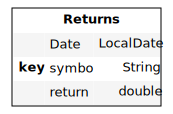

In [29]:
#import graphviz
cube.schema

In [57]:
pip list

Package                 Version
----------------------- ---------
anyio                   3.2.1
argon2-cffi             20.1.0
async-generator         1.10
atomicwrites            1.4.0
atoti                   0.5.5Note: you may need to restart the kernel to use updated packages.

atoti-jupyterlab        0.5.5
attrs                   21.2.0
Babel                   2.9.1
backcall                0.2.0
beautifulsoup4          4.9.3
bleach                  3.3.0
certifi                 2021.5.30
cffi                    1.14.5
chardet                 4.0.0
chart-studio            1.1.0
colorama                0.4.4
colorlover              0.3.0
cufflinks               0.17.3
cvxopt                  1.2.6
cycler                  0.10.0
debugpy                 1.3.0
decorator               5.0.9
defusedxml              0.7.1
entrypoints             0.3
exchange-calendars      3.1.0
FinQuant                0.2.2
graphviz                0.16
idna                    2.10
imgkit                  

In [18]:
#years = 10

import contextlib

stocksp = .2
mfundsp = .1
bondsp = .2
commp = .2

n_portfolio = 100

bestSharpe = 0
runs = 0
weight = None
bestMean = 0
bestStd = 0
means = np.array([])
stds = np.array([])
sharpes = np.array([])
bestWeights = None
weights = np.array([])

#random dates using X_index

randomSet = list(np.sort(np.random.choice(range(0,len(X_index)),nran)))

for tensor in randomSet:
    
    randomsymbols = list(np.random.choice(pf.data.columns,10,replace=False))
    #random columns
    stocks = returns.loc[[i[0] for i in X_index[tensor]]][randomsymbols]
    
    return_vec = np.array(stocks)
    
    #display(pd.DataFrame(stocks.cumsum().iloc[-1]).transpose())

    for _ in range(n_portfolio):    
        means2, stds2, sharpes2, weights2 = np.column_stack([
            random_portfolio(return_vec)
            for _ in range(len(stocks.columns))
        ])    
        means_ = means2
        stds_ = stds2
        sharpes_ = sharpes2
        weights_ = weights2                

        bestWeights = weights_[sharpes_.argmax()]

        means = np.append(means,means_)
        stds = np.append(stds,stds_)
        sharpes = np.append(sharpes,sharpes_)
        weights = np.append(weights,weights_)

    df_ = pd.DataFrame(weights[sharpes.argmax()]).set_index(stocks.columns)
    df_.columns = ['Weights']
            
    next4weeks = returns.loc[[i[0] for i in y_index[tensor]]][randomsymbols]

    df_.sort_values(by=['Weights'],ascending=False,inplace=True)

    wr = np.array(weighted_return(np.array((np.exp(next4weeks)-1).cumsum().tail(1)),weights[sharpes.argmax()]))[0][0]
    
    max_sr_ret = means[sharpes.argmax()]
    max_sr_vol = stds[sharpes.argmax()]
    max_sharpe = sharpes[sharpes.argmax()]

    display([bestWeights, max_sr_ret, max_sr_vol, max_sharpe, wr])


<ipython-input-14-ac01678354e7>:27: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[array([0.07869547352950546, 0.0573858069303265, 0.058837870153691976,
        0.11870471258767011, 0.18422561957612843, 0.18704272237941513,
        0.21198494160405434, 0.05467133159182937, 0.007750952234910514,
        0.04070056941246828], dtype=object),
 0.0007426975621264477,
 0.028719744353543568,
 0.025860173161144813,
 0.08904276598401967]

[array([0.15606864449202987, 0.14194338483844182, 0.1354813118222134,
        0.10516339763895918, 0.10188134365626612, 0.06081686686994875,
        0.13059595330469098, 0.11798887172669695, 0.020114812798593118,
        0.029945412852159715], dtype=object),
 0.0013105532966780486,
 0.02356269213677566,
 0.055619845519799156,
 0.07869874340162301]

[array([0.13097657922027472, 0.18001745924312876, 0.11475165209297736,
        0.1158807612714381, 0.10962246332575734, 0.18689562952271857,
        0.14614103859402525, 0.009366181699243768, 7.056926579842318e-05,
        0.006277665764637743], dtype=object),
 0.0014102572411195812,
 0.020751242547202606,
 0.0679601348165868,
 0.09821208588277937]

[array([0.056015210313239285, 0.14222518467081144, 0.15503456962871504,
        0.011633596184959825, 0.14336641414090853, 0.0837700580627136,
        0.16347372853713144, 0.17089035003612005, 0.06814386615977872,
        0.00544702226562211], dtype=object),
 0.0014102572411195812,
 0.020751242547202606,
 0.0679601348165868,
 -0.07316652873674508]

[array([0.09619866927628691, 0.04636680754161505, 0.02478792998230933,
        0.1168616439056742, 0.06833289855517603, 0.1648260665883093,
        0.19199468251806465, 0.07036365466736097, 0.0850247296882348,
        0.1352429172769686], dtype=object),
 0.0014102572411195812,
 0.020751242547202606,
 0.0679601348165868,
 0.028727960802628443]

[array([0.02760261426235742, 0.018916015037598207, 0.1502654361282476,
        0.011475248319589019, 0.14494018323568136, 0.09266595794381749,
        0.1771233464451086, 0.20629667062744633, 0.06339122158602713,
        0.10732330641412667], dtype=object),
 0.0014102572411195812,
 0.020751242547202606,
 0.0679601348165868,
 0.0013863022173577974]

[array([0.09631930455146169, 0.13677488628017098, 0.172173694703681,
        0.12031226522360335, 0.12182887553470918, 0.02610698889725903,
        0.006813285132522549, 0.07368234372873401, 0.095010994977675,
        0.15097736097018327], dtype=object),
 0.0014102572411195812,
 0.020751242547202606,
 0.0679601348165868,
 0.06886809413764752]

KeyboardInterrupt: 